In [4]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import mplhep as hep
hep.style.use(hep.style.CMS)

import hist as hist2
from coffea import processor
from coffea.analysis_tools import Weights

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch")

In [8]:
def invariant_mass(jet1, jet2):
    """di-jet invariant mass"""
    return np.sqrt(2 * jet1.pt * jet2.pt * (np.cosh(jet1.eta - jet2.eta) - np.cos(jet1.phi - jet2.phi)))


class BackgroundProcessor(processor.ProcessorABC):
    def __init__(self):
        
        # here we define an output
        self.make_output = lambda: {
            'sumw': 0.,
            "leading_jet_kin": hist2.Hist(
                hist2.axis.Regular(50, 30, 1000, name="jet_pt", label=r"Jet $p_T$ [GeV]"),
                hist2.axis.Regular(20, -5, 5, name="jet_eta", label=r"Jet $\eta$"),
                hist2.axis.Regular(30, 0, 200, name="jet_mass", label=r"Jet $m$ [GeV]"),
                hist2.storage.Weight(),
            ),
            "met_kin": hist2.Hist(
                hist2.axis.Regular(50, 0, 1000, name="met_pt", label=r"$p_T^{miss}$ [GeV]"),
                hist2.storage.Weight(),
            ),
            'kin': hist2.Hist(
                hist2.axis.Regular(30, 0, 1000, name='H', label='$H_T$ [GeV]'),
                hist2.axis.Regular(30, 0, 4, name='leadingJetsDphi', label='$|\Delta \phi (J_1, J_2)|$'),
                hist2.axis.Regular(30, 0, 5000, name='invariantMass', label=r"$m_{jj}^{max}$ [GeV]"),
                hist2.axis.Regular(20, 0, 10, name='maxDeltaEta', label="max $|\Delta \eta (J_i, J_j)|$"),
                hist2.axis.Regular(20, 0, 4, name="minDeltaPhi", label="min $|\Delta \phi (p_T^{miss}, J_i)|$"),
                hist2.storage.Weight(),
            ),
        }
        
    def process(self, events):
        dataset = events.metadata['dataset']
        weights = Weights(len(events), storeIndividual=True)
        weights.add('genweight', events.genWeight)
        
        output = self.make_output()
        output['sumw'] = ak.sum(events.genWeight)
        
        # jets
        jets = events.Jet
        
        # select events with at least two jets
        two_jets = ak.sum(jets.pt > 0, axis=1) > 1
        jets = jets[two_jets]
        
        # leading jets deltaPhi
        ledjets_dphi = jets[:,0].delta_phi(jets[:,1])
                
            
        # jets four vectors
        jet_events = ak.zip(
            {
                "pt": jets.pt,
                "eta": jets.eta,
                "phi": jets.phi,
                "mass": jets.mass
            }
        )
        # get combinations of jet pairs
        jet_pairs = ak.combinations(jet_events, 2)
        jp_one, jp_two = ak.unzip(jet_pairs) 
        
        # compute the invariant mass for every pair of jets
        # and select the maximum value
        max_mjj = ak.max(invariant_mass(jp_one, jp_two), axis=1)
        
        # met
        met = events.MET
        met = met[two_jets]
        
        # minimun phi difference between jets and met
        min_dphi_met_jet = abs(ak.min(jets.delta_phi(met), axis=1))
                
        # max delta eta between jets
        max_delta_eta = abs(ak.max(jp_one.eta - jp_two.eta, axis=1))
                
            
        # function to normalize arrays after a cut or selection
        def normalize(val, cut=None):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
    
        # here we fill our histograms
        output["leading_jet_kin"].fill(
            jet_pt=normalize(ak.firsts(jets.pt)),
            jet_eta=normalize(ak.firsts(jets.eta)),
            jet_mass=normalize(ak.firsts(jets.mass)),
            weight=weights.weight()[two_jets],
        )
        output["met_kin"].fill(
            met_pt=normalize(met.pt),
            weight=weights.weight()[two_jets],
        )
        output['kin'].fill(
            H=normalize(ak.sum(jets.pt, axis=1)),
            leadingJetsDphi = normalize(ledjets_dphi),
            invariantMass = normalize(max_mjj),
            maxDeltaEta = normalize(max_delta_eta),
            minDeltaPhi = normalize(min_dphi_met_jet),
            weight=weights.weight()[two_jets],
        )
        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

In [6]:
# define the dask client
from dask.distributed import Client

client = Client("tls://daniel-2eocampo-2ehenao-40cern-2ech.dask.coffea.casa:8786")
client

<Client: 'tls://192.168.147.144:8786' processes=2 threads=4, memory=12.72 GiB>

In [9]:
# data fileset 
fileset = {
    'zjets': 
    ["root://xcache/" + file for file in np.loadtxt("data/zjets100200.txt", dtype=str)][:2] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets200400.txt", dtype=str)][:2] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets400600.txt", dtype=str)][:2] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets600800.txt", dtype=str)][:2] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets8001200.txt", dtype=str)][:2] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets12002500.txt", dtype=str)][:2] +
    ["root://xcache/" + file for file in np.loadtxt("data/zjets2500Inf.txt", dtype=str)][:2] 
}

# run the processor with the NanoAOD schema and the dask client
out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=BackgroundProcessor(),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
        maxchunks=30,
    )

In [11]:
ledjet = out["zjets"]["leading_jet_kin"]
met = out["zjets"]["met_kin"]
h = out["zjets"]["kin"]

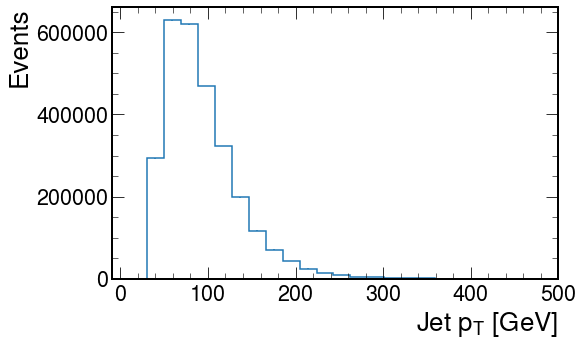

In [14]:
fig, ax = plt.subplots(figsize=(8,5))

ledjet[{"jet_eta":sum, "jet_mass":sum}].plot1d(ax=ax)

ax.set(
    ylabel="Events",
    xlim=(-10, 500),
);

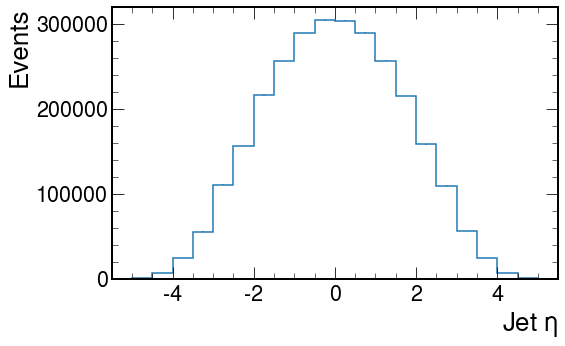

In [16]:
fig, ax = plt.subplots(figsize=(8,5))

ledjet[{"jet_pt":sum, "jet_mass":sum}].plot1d(ax=ax)

ax.set(ylabel="Events");

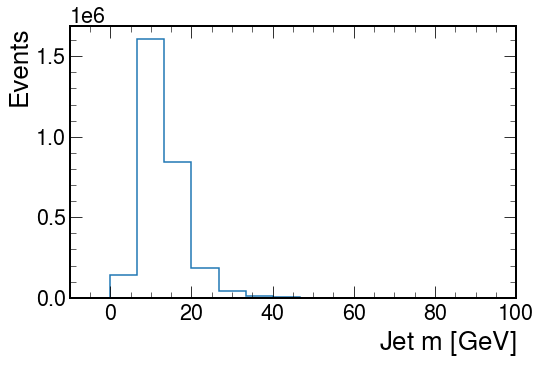

In [18]:
fig, ax = plt.subplots(figsize=(8,5))

ledjet[{"jet_eta":sum, "jet_pt":sum}].plot1d(ax=ax)

ax.set(
    ylabel="Events",
    xlim=(-10, 100),
);

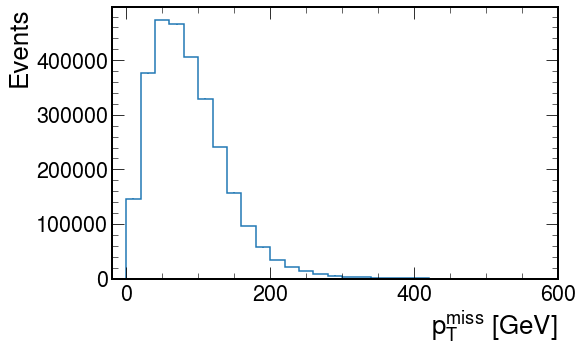

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

met.plot1d(ax=ax)

ax.set(
    ylabel="Events",
    xlim=(-20, 600),
);

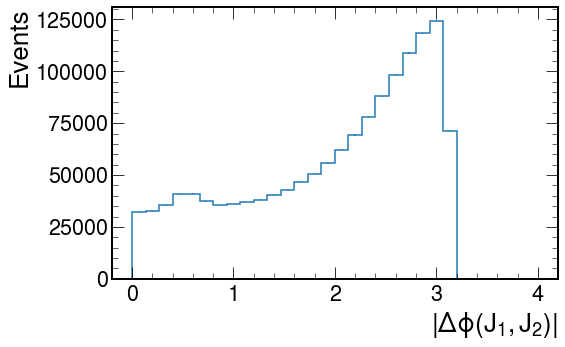

In [20]:
fig, ax = plt.subplots(figsize=(8,5))

h[{"H":sum,"invariantMass":sum, "maxDeltaEta":sum, "minDeltaPhi":sum}].plot1d(ax=ax)

ax.set(ylabel="Events");

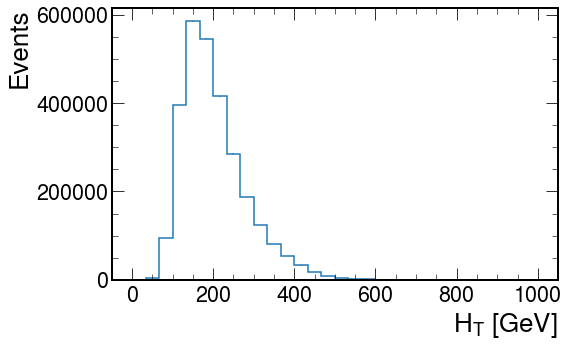

In [21]:
fig, ax = plt.subplots(figsize=(8,5))

h[{"leadingJetsDphi":sum, "invariantMass":sum, "maxDeltaEta":sum, "minDeltaPhi":sum}].plot1d(ax=ax)

ax.set(ylabel="Events");